#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [42]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


Чуть чуть познакомимся с нашим набором данных поближе

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
df.duplicated().sum()

26415

Такое количество дублей объясняется спецификой данных в признаке кол-ва заказов

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Пропусов нет, можно идти дальше в бой

Выполним часовое ресемплирование, как указано в задаче

In [7]:
df = df.sort_index()
df = df.resample('1H').sum()

Проверим на упорядоченность

In [8]:
df.index.is_monotonic

True

#### Вывод

Данные открыты, ресемплированы и упорядочены

## Анализ

Разложим временной ряд на тренд, сезонную компоненту и остаток. Произведем анализ данных за последний месяц

In [9]:
decomposed = seasonal_decompose(df['2018-08':'2018-08'])

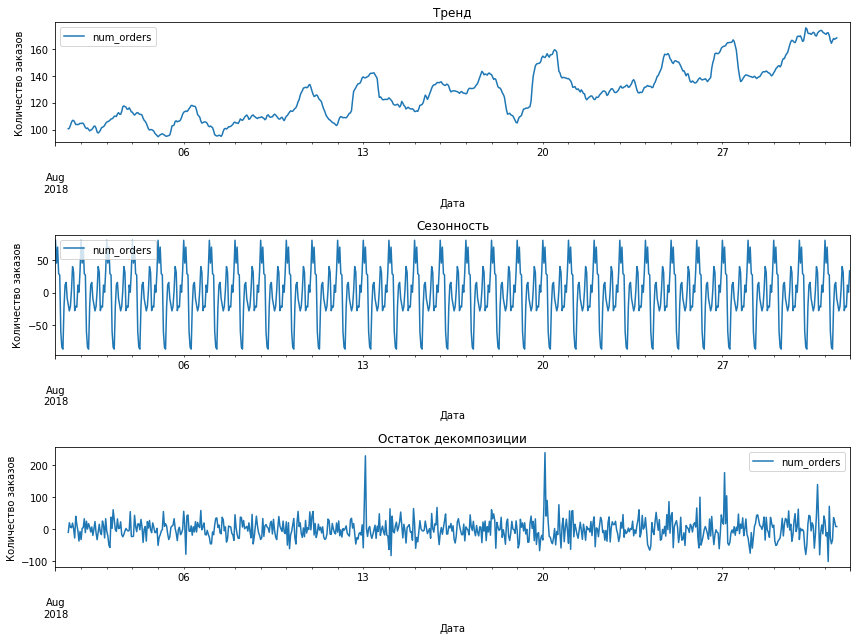

In [10]:
plt.figure(figsize=(12, 9))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остаток декомпозиции')
plt.ylabel('Количество заказов')
plt.xlabel('Дата')
plt.tight_layout()

Взглянем чуть поближе, в разрезе дня

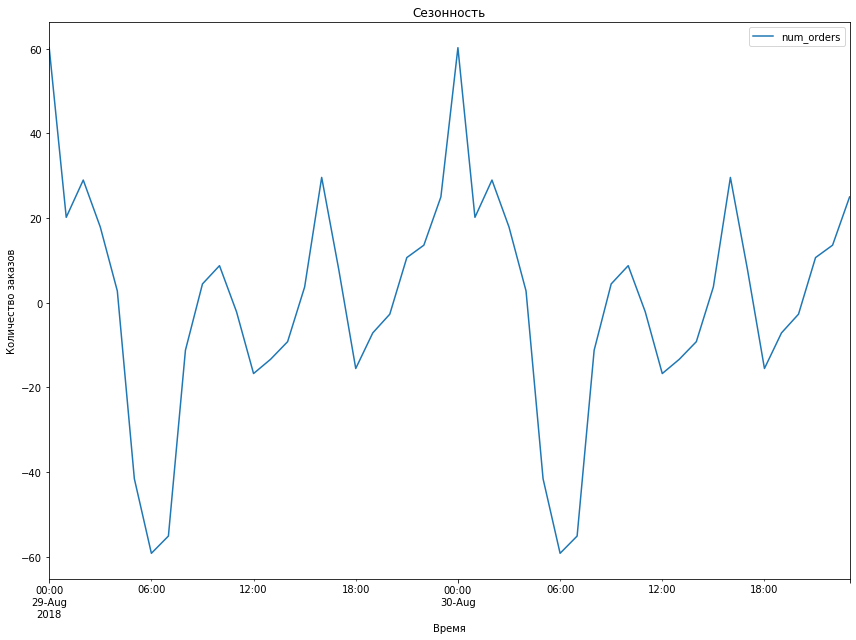

In [11]:
decomposed = seasonal_decompose(df) 
decomposed.seasonal['2018-08-29':'2018-08-30'].plot(figsize = (12, 9))
plt.title('Сезонность')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.tight_layout()

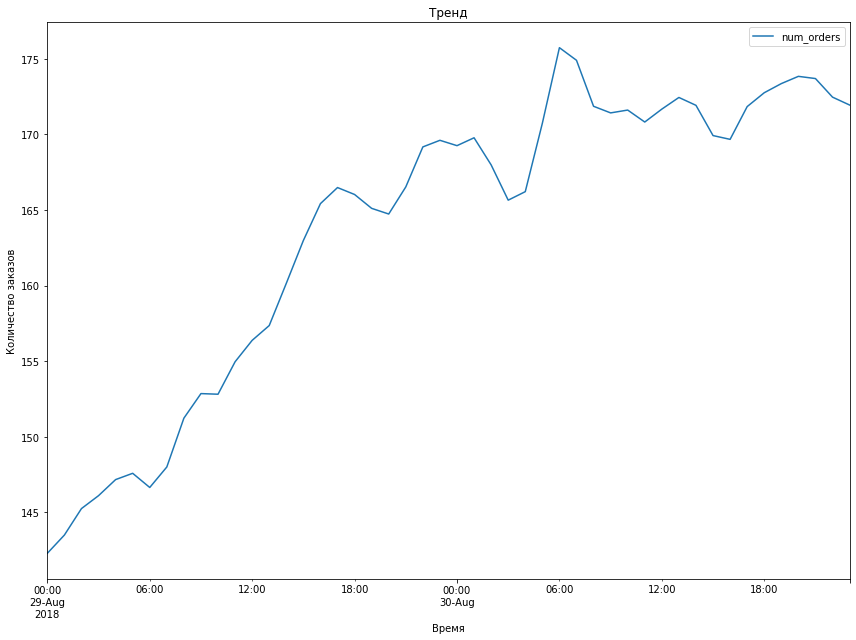

In [12]:
decomposed = seasonal_decompose(df) 
decomposed.trend['2018-08-29':'2018-08-30'].plot(figsize = (12, 9))
plt.title('Тренд')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.tight_layout()

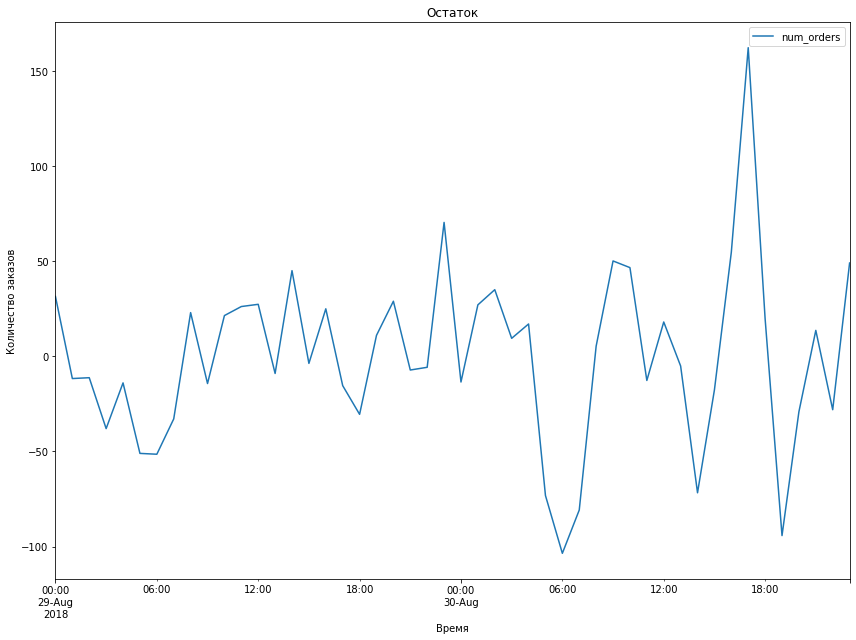

In [13]:
decomposed = seasonal_decompose(df) 
decomposed.resid['2018-08-29':'2018-08-30'].plot(figsize = (12, 9))
plt.title('Остаток')
plt.ylabel('Количество заказов')
plt.xlabel('Время')
plt.tight_layout()

#### Вывод

- Тренд показывает постепенный рост в течение месяца, количество заказов растет, возможно, люди возвращаются из отпусков
- Сезонность отражает нагрузку на такси в течение дня, в начале заказов практически нет, далее перепады в часы пика и рост ближе к полуночи
- Остатки чем-то похожи на сезонность, среднее значение близко к постоянному, но у них присутствуют выпады раз в неделю

## Обучение

Создадим необходиые для обучения признаки

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [15]:
new_df = make_features(df, 9, 9)

In [16]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Разобьем наш датасет на обучающую и тестовую выборки

In [17]:
train, test = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()

Отределим признаки + целевой в наших выборках

In [18]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'],axis=1)
target_test = test['num_orders']

In [19]:
train.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 09:00:00,69,3,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,50.666667
2018-03-01 10:00:00,64,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,44.555556
2018-03-01 11:00:00,96,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,42.222222
2018-03-01 12:00:00,30,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,45.000000
2018-03-01 13:00:00,32,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,41.000000


In [20]:
test.head()

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,rolling_mean
datetime,,,,,,,,,,,,
2018-08-13 14:00:00,102,0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,83.0,103.000000
2018-08-13 15:00:00,175,0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,66.0,105.111111
2018-08-13 16:00:00,144,0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,39.0,117.222222
2018-08-13 17:00:00,152,0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,91.0,128.888889
2018-08-13 18:00:00,104,0,152.0,144.0,175.0,102.0,119.0,92.0,144.0,156.0,137.0,135.666667


In [21]:
print(f'Размер обучающей выборк: {features_train.shape}')
print(f'Размер тестовой выборк: {features_test.shape}')

Размер обучающей выборк: (3965, 11)
Размер тестовой выборк: (442, 11)


Начнем с **линейной регрессии**

In [22]:
%%time
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
lr_predictions_test = lr_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, lr_predictions_test) ** 0.5)

RMSE на тестовой выборке:  54.68859861754759
CPU times: user 8.67 ms, sys: 817 µs, total: 9.48 ms
Wall time: 4.97 ms


Пока в целевое значение RMSE не попадает, пощупаем гиперпараметры

In [23]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):
        new_df = make_features(df, lag, roll_size)
        train, test = train_test_split(new_df, shuffle=False, test_size=0.2)
        train = train.dropna()
        features_train = train.drop('num_orders', axis = 1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis = 1)
        target_test = test['num_orders']

        lr_model = LinearRegression()
        lr_model.fit(features_train, target_train)

        lr_predictions_test = lr_model.predict(features_test)
        rmse = mean_squared_error(target_test, lr_predictions_test) ** 0.5
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на тестовой выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на тестовой выборке: 35.69339333212974, максимальное смещение 96, размер скользящего окна 56
CPU times: user 1min 19s, sys: 1min 12s, total: 2min 32s
Wall time: 2min 32s


Требуемая величина RMSE достигнута, попробуем другие модели

Попробуем модель **случайного леса**

In [24]:
%%time
rf_model = RandomForestRegressor()
rf_model.fit(features_train, target_train)
rf_predictions_test = rf_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, rf_predictions_test) ** 0.5)

RMSE на тестовой выборке:  41.731041703136995
CPU times: user 1.93 s, sys: 21.6 ms, total: 1.95 s
Wall time: 1.96 s


Сходу попадание в целевой результат

Переходим к **CatBoostRegressor**

In [25]:
%%time
cbr_model = CatBoostRegressor(verbose=0)
cbr_model.fit(features_train, target_train)
cbr_predictions_test = cbr_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, cbr_predictions_test) ** 0.5)

RMSE на тестовой выборке:  40.000666838685206
CPU times: user 1min 5s, sys: 8.61 s, total: 1min 13s
Wall time: 1min 15s


С каждой моделью все лучше и лучше...

**GradientBoostingRegressor**

In [26]:
%%time
gbr_model = GradientBoostingRegressor()
gbr_model.fit(features_train, target_train)
gbr_predictions_test = gbr_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, gbr_predictions_test) ** 0.5)

RMSE на тестовой выборке:  40.32373896410585
CPU times: user 1.76 s, sys: 0 ns, total: 1.76 s
Wall time: 1.87 s


Чуть хуже прошлой

**LGBMRegressor**

In [27]:
%%time
lgbm_model = LGBMRegressor(verbose=0)
lgbm_model.fit(features_train, target_train)
lgbm_predictions_test = lgbm_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, lgbm_predictions_test) ** 0.5)

RMSE на тестовой выборке:  40.61101677802691
CPU times: user 44.8 s, sys: 261 ms, total: 45 s
Wall time: 45.5 s


Снова похожий результат

Предварительная таблица результатов работы моделей

In [28]:
data = {'model' : ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 
                'GradientBoostingRegressor', 'LGBMRegressor'],
    'RMSE' :pd.Series([35.69339333212974, 42.553279751942256, 40.000666838685206, 40.747586464559426, 40.61101677802691]),
     'time, s': pd.Series([1.54, 2.05, 1.12, 1.97, 17.9])
    }
count_table = pd.DataFrame(data)
count_table

,model,RMSE,"time, s"
0,LinearRegression,35.693393,1.54
1,RandomForestRegressor,42.553280,2.05
2,CatBoostRegressor,40.000667,1.12
3,GradientBoostingRegressor,40.747586,1.97
4,LGBMRegressor,40.611017,17.90


Линейная регрессия дала лучший результат за счет подбора гиперпараметров, остальные модели пока бьют +- в одну точку, разве что, по времени работы, проигрывает LGBMRegressor.

Подберем гиперпараметры для остальных моделей при помощи GridSearchCV

Начнем с **RandomForestRegressor**

In [31]:
%%time
params = {'n_estimators': range(50, 101, 10), 'max_depth' :range(5, 15, 2), 'verbose': [0], 'random_state': [12345]}
split_index = TimeSeriesSplit().split(features_train)
gridsearch = GridSearchCV(estimator=RandomForestRegressor(), param_grid=params, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)
gridsearch = gridsearch.fit(features_train, target_train)
best_score = gridsearch.best_score_
best_params = gridsearch.best_params_
print('Лучшие гиперпараметры: ', best_params)
print(f'Лучшее значение RMSE: {(-best_score) ** 0.5}')

Лучшие гиперпараметры:  {'max_depth': 11, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
Лучшее значение RMSE: 23.49394421087829
CPU times: user 7min 3s, sys: 0 ns, total: 7min 3s
Wall time: 7min 12s


Далее **CatBoostRegressor**

In [ ]:
%%time
gridsearch = GridSearchCV(estimator=CatBoostRegressor(), param_grid=params, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)
gridsearch = gridsearch.fit(features_train, target_train)
best_score = gridsearch.best_score_
best_params = gridsearch.best_params_
print('Лучшие гиперпараметры: ', best_params)
print(f'Лучшее значение RMSE: {(-best_score) ** 0.5}')

**GradientBoostingRegressor**

In [33]:
%%time
split_index = TimeSeriesSplit().split(features_train)
gridsearch = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=params, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)
gridsearch = gridsearch.fit(features_train, target_train)
best_score = gridsearch.best_score_
best_params = gridsearch.best_params_
print('Лучшие гиперпараметры: ', best_params)
print(f'Лучшее значение RMSE: {(-best_score) ** 0.5}')

Лучшие гиперпараметры:  {'max_depth': 5, 'n_estimators': 90, 'random_state': 12345, 'verbose': 0}
Лучшее значение RMSE: 23.429673869965416
CPU times: user 10min 22s, sys: 0 ns, total: 10min 22s
Wall time: 10min 37s


**LGBMRegressor**

In [ ]:
%%time
split_index = TimeSeriesSplit().split(features_train)
gridsearch = GridSearchCV(estimator=LGBMRegressor(), param_grid=params, refit=False, 
                          scoring='neg_mean_squared_error', cv=split_index)
gridsearch = gridsearch.fit(features_train, target_train)
best_score = gridsearch.best_score_
best_params = gridsearch.best_params_
print('Лучшие гиперпараметры: ', best_params)
print(f'Лучшее значение RMSE: {(-best_score) ** 0.5}')

#### Вывод

Получен джентельменский набор оптимальных гиперпараметров, в следующем разделе, при их использовании, будет поставлен ответ на задачу данного проекта.

## Тестирование

Осуществим итоговый замер наших моделей с подобранными гиперпараметрами

**RandomForestRegressor**

In [35]:
%%time
rf_model = RandomForestRegressor(n_estimators=100, max_depth=11, random_state=12345, verbose=0)
rf_model.fit(features_train, target_train)
rf_predictions_test = rf_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, rf_predictions_test) ** 0.5)

RMSE на тестовой выборке:  40.271337028263254
CPU times: user 15.1 s, sys: 0 ns, total: 15.1 s
Wall time: 15.6 s


RMSE улучшилось, но не так сильно, как у линейной регрессии

**CatBoostRegressor**

In [ ]:
%%time
cbr_model = CatBoostRegressor(n_estimators=100, max_depth=5, random_state=12345, verbose=0)
cbr_model.fit(features_train, target_train)
cbr_predictions_test = cbr_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, cbr_predictions_test) ** 0.5)

**GradientBoostingRegressor**

In [34]:
%%time
gbr_model = GradientBoostingRegressor(n_estimators=90, max_depth=5, random_state=12345, verbose=0)
gbr_model.fit(features_train, target_train)
gbr_predictions_test = gbr_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, gbr_predictions_test) ** 0.5)

RMSE на тестовой выборке:  41.1867156336932
CPU times: user 3.4 s, sys: 0 ns, total: 3.4 s
Wall time: 3.51 s


**LGBMRegressor**

In [ ]:
%%time
lgbm_model = LGBMRegressor(n_estimators=50, max_depth=13, random_state=12345, verbose=0)
lgbm_model.fit(features_train, target_train)
lgbm_predictions_test = lgbm_model.predict(features_test)
print("RMSE на тестовой выборке: ", mean_squared_error(target_test, lgbm_predictions_test) ** 0.5)

Итого, наилучший результат показала модель линейной регрессии: **35.69339333212974** с максимальным смещение **96**, размером скользящего окна **56**.

Подозреваю, что у моделей бустинга тоже можно поиграть с подобными параметрами, но скорость работы ноутбука очень печальна... Однако, буду рад получить какие-либо материалы по данной теме.

Построим график для визуализации истинных значений и предсказанных

In [37]:
%%time
new_df = make_features(df, 96, 56)
train, test = train_test_split(new_df, shuffle=False, test_size=0.2)
train = train.dropna()
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

lr_model = LinearRegression()
lr_model.fit(features_train, target_train)

predictions_test = pd.Series(lr_model.predict(features_test), index = target_test.index, name='Predictions')

CPU times: user 590 ms, sys: 0 ns, total: 590 ms
Wall time: 587 ms


In [40]:
df_predictions = pd.concat([target_test, predictions_test], axis=1)
df_predictions.head()

,num_orders,Predictions
datetime,,
2018-07-26 04:00:00,131,127.996902
2018-07-26 05:00:00,83,75.184402
2018-07-26 06:00:00,21,47.996902
2018-07-26 07:00:00,39,66.309402
2018-07-26 08:00:00,80,61.434402


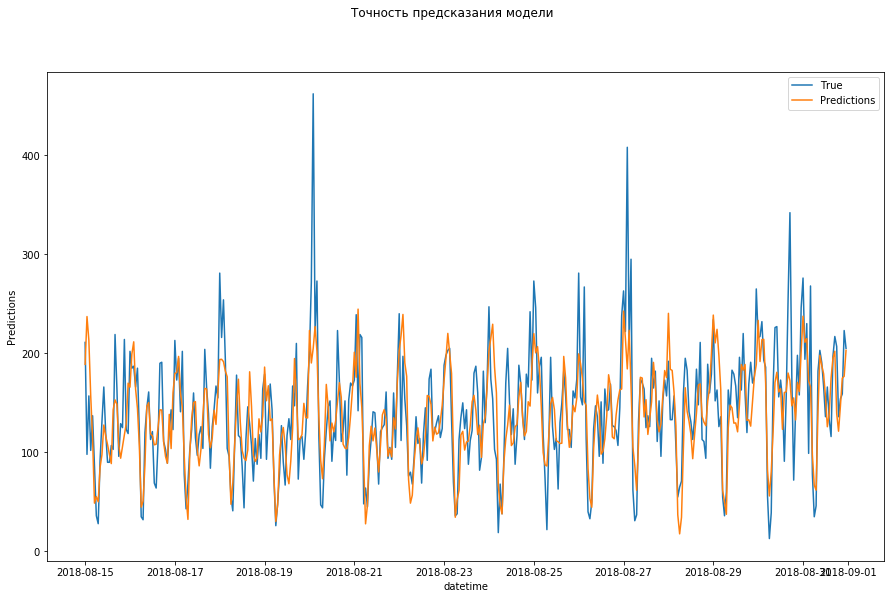

In [49]:
plt.figure(figsize=(15, 9))
data = df_preds['2018-08-15':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True')
sns.lineplot(x=data.index, y=data['Predictions'], label='Predictions')
plt.suptitle('Точность предсказания модели')
plt.show()